# S&P 500 Trading Algorithm

This notebook implements a trading algorithm for the S&P 500 using machine learning models. We will use available parameters as signals and build models like FFNN, LSTM, and CNN.

## Step 1: Data Loading and Exploration

In [58]:
import pandas as pd
import numpy as np


# Load the CSV data
data = pd.read_csv('/Users/rafaeldubach/Quantitative_Trading_Algorithm/output.csv')

# Print the columns to understand the data structure
print("Data Columns:")
print(data.columns)

# Based on the legend, we should map these columns to lowercase
selected_columns = [
    'emp', 'pe', 'cape', 'dy', 'rho', 'mov', 'ir', 'rr',
    'y02', 'y10', 'stp', 'cf', 'mg', 'rv', 'ed', 'un',
    'gdp', 'm2', 'cpi', 'dil', 'yss', 'nyf',
    '_au', '_dxy', '_lcp', '_ty', '_oil',
    '_mkt', '_va', '_gr'
]

# Check if the selected columns are in the data
available_columns = [col for col in selected_columns if col in data.columns]
print("Selected Available Columns:")
print(available_columns)

# Extracting the relevant columns
data = data[available_columns + ['snp']]  # Including 'snp' as target

Data Columns:
Index(['emp', 'pe', 'cape', 'dy', 'rho', 'mov', 'ir', 'rr', 'y02', 'y10',
       'stp', 'cf', 'mg', 'rv', 'ed', 'un', 'gdp', 'm2', 'cpi', 'dil', 'yss',
       'nyf', '_au', '_dxy', '_lcp', '_ty', '_oil', '_mkt', '_va', '_gr',
       'snp', 'label'],
      dtype='object')
Selected Available Columns:
['emp', 'pe', 'cape', 'dy', 'rho', 'mov', 'ir', 'rr', 'y02', 'y10', 'stp', 'cf', 'mg', 'rv', 'ed', 'un', 'gdp', 'm2', 'cpi', 'dil', 'yss', 'nyf', '_au', '_dxy', '_lcp', '_ty', '_oil', '_mkt', '_va', '_gr']


## Step 2: Preprocess and Feature Engineering

In [59]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Handle missing values
data = data.dropna()

# Extract features and target
features = data.drop(columns=['snp'])
target = data['snp']

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

print("Feature Engineering and Data Preprocessing Complete.")


Feature Engineering and Data Preprocessing Complete.


## Step 3: Custom Train-Test Split for LSTM

In [60]:
# Custom function to split data for each year to keep the data sequential
def custom_train_test_split(features, target, train_size=42, test_size=10):
    X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []
    for start in range(0, len(features), train_size + test_size):
        end_train = start + train_size
        end_test = end_train + test_size
        if end_test <= len(features):
            X_train_list.append(features[start:end_train])
            y_train_list.append(target[start:end_train])
            X_test_list.append(features[end_train:end_test])
            y_test_list.append(target[end_train:end_test])
    
    X_train_lstm_prepared = np.concatenate(X_train_list)
    y_train_lstm_prepared = np.concatenate(y_train_list)
    X_test_lstm_prepared = np.concatenate(X_test_list)
    y_test_lstm_prepared = np.concatenate(y_test_list)
    
    return X_train_lstm_prepared, y_train_lstm_prepared, X_test_lstm_prepared, y_test_lstm_prepared

# Split the data using the custom function
X_train_lstm_prepared, y_train_lstm_prepared, X_test_lstm_prepared, y_test_lstm_prepared = custom_train_test_split(features_scaled, target)

# Reshape data for LSTM (needs 3D input)
X_train_lstm = X_train_lstm_prepared.reshape((X_train_lstm_prepared.shape[0], 1, X_train_lstm_prepared.shape[1]))
X_test_lstm = X_test_lstm_prepared.reshape((X_test_lstm_prepared.shape[0], 1, X_test_lstm_prepared.shape[1]))


## Step 4: Model Implementation

### Feed-Forward Neural Network (FFNN)

In [61]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Define the FFNN model creation function
def create_ffnn_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Training with all parameters
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ffnn_model = create_ffnn_model(X_train_scaled.shape[1])
ffnn_history = ffnn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

ffnn_evaluation = ffnn_model.evaluate(X_test_scaled, y_test)
print(f"FFNN Model Test Loss: {ffnn_evaluation}")

ffnn_predictions = ffnn_model.predict(X_test_scaled)
print("FFNN Model Training and Evaluation Complete.")

Epoch 1/50


/Users/rafaeldubach/miniconda3/envs/DL/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3947150.0000 - val_loss: 3820533.5000
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - loss: 3988193.7500 - val_loss: 3506498.2500
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - loss: 3288897.0000 - val_loss: 2555007.2500
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 2373285.5000 - val_loss: 1177943.2500
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 1007493.1875 - val_loss: 363093.2812
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 371772.0000 - val_loss: 192657.6562
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - loss: 249415.4375 - val_loss: 149159.6719
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 214471.4062 - val_loss: 122296.5469
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 196380.8438 - val_loss: 102481.7969
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 179244.3750 - val_loss: 87189.7734
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 603u

### Long Short-Term Memory Network (LSTM)

Epoch 1/40


/Users/rafaeldubach/miniconda3/envs/DL/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1410418.7500 - val_loss: 12300868.0000
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1378203.0000 - val_loss: 12293606.0000
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1394101.2500 - val_loss: 12277213.0000
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1393372.1250 - val_loss: 12242215.0000
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1358129.5000 - val_loss: 12182967.0000
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1383410.5000 - val_loss: 12079324.0000
Epoch 7/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1330380.8750 - val_loss: 11909512.0000
Epoch 8/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1347671.2500 - val_loss: 11665310.0000
Epoch 9/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1275985.6250 - val_loss: 11355491.0000
Epoch 10/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1237613.6250 - val_loss: 10967446.0000
Epoch 11/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0

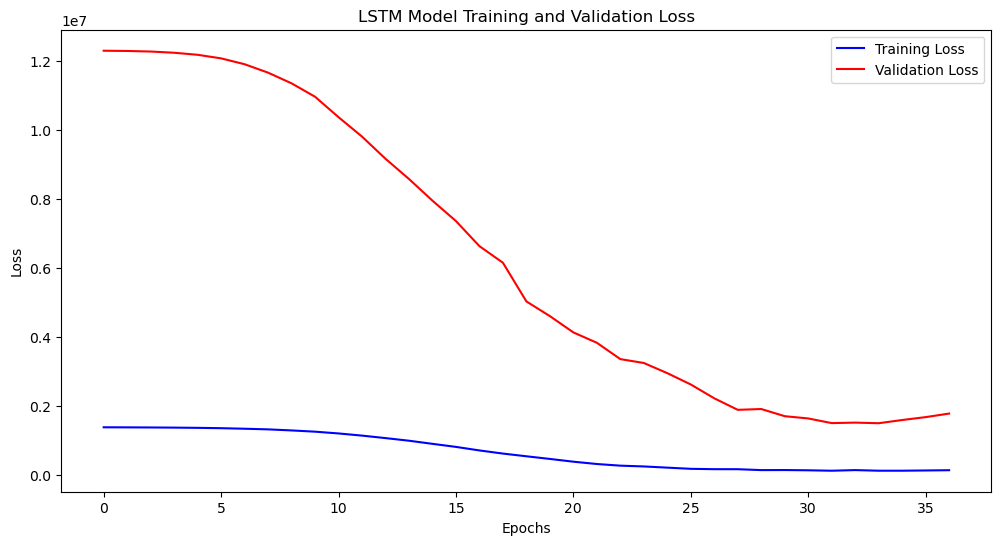

In [62]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Define the LSTM model creation function
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(10, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.5))  # Add dropout for regularization
    model.add(BatchNormalization())  # Add batch normalization
    model.add(Dense(32, activation='relu'))  # Add an additional dense layer
    model.add(Dropout(0.5))  # Add another dropout for regularization
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Training with all parameters
lstm_model = create_lstm_model((X_train_lstm.shape[1], X_train_lstm.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lstm_history = lstm_model.fit(X_train_lstm, y_train_lstm_prepared, epochs=40, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stop])

lstm_evaluation = lstm_model.evaluate(X_test_lstm, y_test_lstm_prepared)
print(f"LSTM Model Test Loss: {lstm_evaluation}")

lstm_predictions = lstm_model.predict(X_test_lstm)
print("LSTM Model Training and Evaluation Complete.")

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(lstm_history.history['loss'], label='Training Loss', color='blue')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss', color='red')
plt.title('LSTM Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# LSTM NEW --------------------------------------------------------

### Convolutional Neural Network (CNN)

In [63]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Reshape, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))

# Define the CNN model creation function
def create_cnn_model(input_dim):
    model = Sequential()
    model.add(Reshape((input_dim, 1), input_shape=(input_dim,)))
    model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Dropout(0.25))  # Dropout layer to reduce overfitting
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Training with all parameters
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

cnn_model = create_cnn_model(X_train_scaled.shape[1])
cnn_history = cnn_model.fit(X_train_scaled, y_train, epochs=40, batch_size=16, validation_split=0.2, verbose=1)

cnn_evaluation = cnn_model.evaluate(X_test_scaled, y_test)
print(f"CNN Model Test Loss: {cnn_evaluation}")

cnn_predictions = cnn_model.predict(X_test_scaled)
print("CNN Model Training and Evaluation Complete.")


Epoch 1/40


/Users/rafaeldubach/miniconda3/envs/DL/lib/python3.9/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3400545.7500 - val_loss: 1140058.0000
Epoch 2/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1132269.0000 - val_loss: 819129.5625
Epoch 3/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 799447.6250 - val_loss: 353028.0625
Epoch 4/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 267586.0000 - val_loss: 145324.6094
Epoch 5/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 136306.2812 - val_loss: 89110.6328
Epoch 6/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 87963.2422 - val_loss: 63407.1055
Epoch 7/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 71720.5781 - val_loss: 48932.1602
Epoch 8/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 52021.2344 - val_loss: 40726.8398
Epoch 9/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 47364.3672 - val_loss: 32852.4883
Epoch 10/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38666.3242 - val_loss: 28277.9473
Epoch 11/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27760.1582 - val_lo

# XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

From here trash code

Dave Evaluation of Strategy:
- [ ] Sharpe Ratio -> Verschoben auf nach Strategie Implementation
- [ ] In sample, out sample performance
- [ ] Information Coefficient


Rafael
- [ ] Use Multiple Sets of Signals

Felix
- [ ] Write shit
- [ ] Hyperparameter Tuning (Optional)

After:
- [ ] Hyperparameter Tuning
- [ ] Data Augmentation


## Step 5: Backtest and Evaluate the Strategy

In [64]:
import numpy as np

# Define a simple trading strategy
def trading_strategy(predictions, actual_prices):
    # Align the lengths by dropping the last element of the predictions array to match actual_prices
    predictions = predictions[:-1]
    actual_prices = actual_prices[:-1]
    
    # Create signals: 1 for buy, -1 for sell
    signals = np.where(predictions > actual_prices, 1, -1)
    
    # Calculate returns based on signals
    aligned_actual_prices = actual_prices[1:]  # Align for the same shape
    returns = signals[:-1] * (aligned_actual_prices - actual_prices[:-1])
    return returns

# Backtest the strategy with FFNN predictions
ffnn_returns = trading_strategy(ffnn_predictions.flatten(), y_test.values)
ffnn_sharpe_ratio = np.mean(ffnn_returns) / np.std(ffnn_returns) * np.sqrt(52)  # Annualized Sharpe ratio

print(f"FFNN Trading Strategy Sharpe Ratio: {ffnn_sharpe_ratio}")

# Backtest with LSTM predictions
lstm_returns = trading_strategy(lstm_predictions.flatten(), y_test_lstm_prepared)
lstm_sharpe_ratio = np.mean(lstm_returns) / np.std(lstm_returns) * np.sqrt(52)

print(f"LSTM Trading Strategy Sharpe Ratio: {lstm_sharpe_ratio}")

# Backtest with CNN predictions
cnn_returns = trading_strategy(cnn_predictions.flatten(), y_test.values)
cnn_sharpe_ratio = np.mean(cnn_returns) / np.std(cnn_returns) * np.sqrt(52)

print(f"CNN Trading Strategy Sharpe Ratio: {cnn_sharpe_ratio}")

print("Backtesting and Evaluation Complete.")


FFNN Trading Strategy Sharpe Ratio: 0.7363609101808658
LSTM Trading Strategy Sharpe Ratio: -0.4167097642895023
CNN Trading Strategy Sharpe Ratio: -0.5909532211235613
Backtesting and Evaluation Complete.


## Step 5: Calculate Model Accuracy

### Step 1: Calculate Model Accuracy
We will evaluate the model's accuracy using metrics such as Mean Squared Error (MSE) and R-squared.

In [65]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate and print model accuracy for FFNN
ffnn_mse = mean_squared_error(y_test, ffnn_predictions)
ffnn_r2 = r2_score(y_test, ffnn_predictions)
print(f"FFNN Model MSE: {ffnn_mse}")
print(f"FFNN Model R-squared: {ffnn_r2}")

# Calculate and print model accuracy for LSTM
lstm_mse = mean_squared_error(y_test_lstm_prepared, lstm_predictions)
lstm_r2 = r2_score(y_test_lstm_prepared, lstm_predictions)
print(f"LSTM Model MSE: {lstm_mse}")
print(f"LSTM Model R-squared: {lstm_r2}")

# Calculate and print model accuracy for CNN
cnn_mse = mean_squared_error(y_test, cnn_predictions)
cnn_r2 = r2_score(y_test, cnn_predictions)
print(f"CNN Model MSE: {cnn_mse}")
print(f"CNN Model R-squared: {cnn_r2}")


FFNN Model MSE: 17803.85380398751
FFNN Model R-squared: 0.987987247744591
LSTM Model MSE: 416017.3807567852
LSTM Model R-squared: 0.7097791772274378
CNN Model MSE: 8485.404107699494
CNN Model R-squared: 0.9942746633141869


### Step 2: Show and Discuss Results
We will create charts to visualize the actual vs. predicted values for each model and discuss the results.

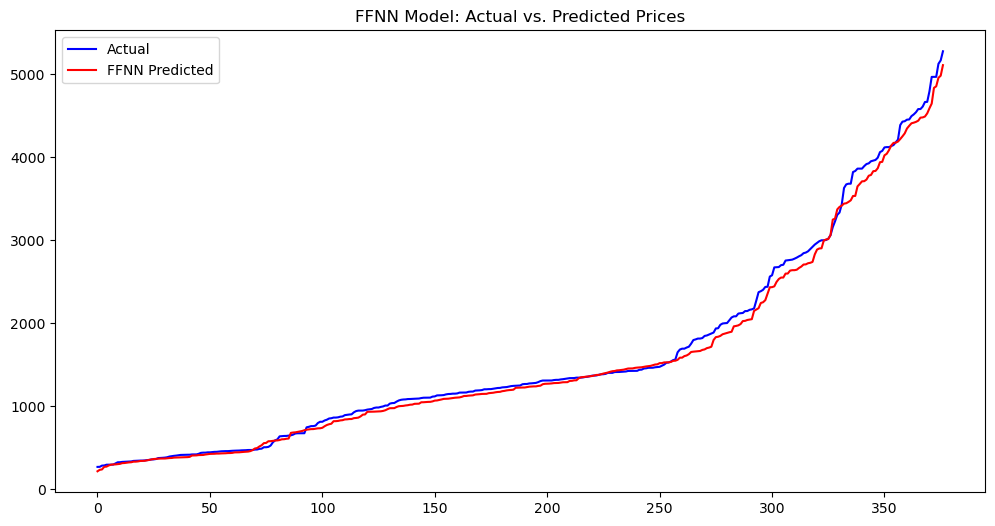

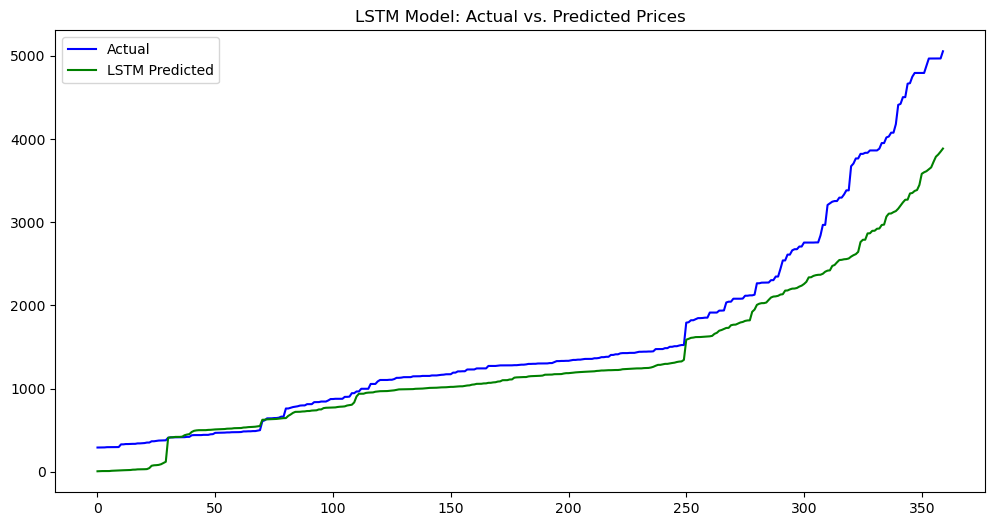

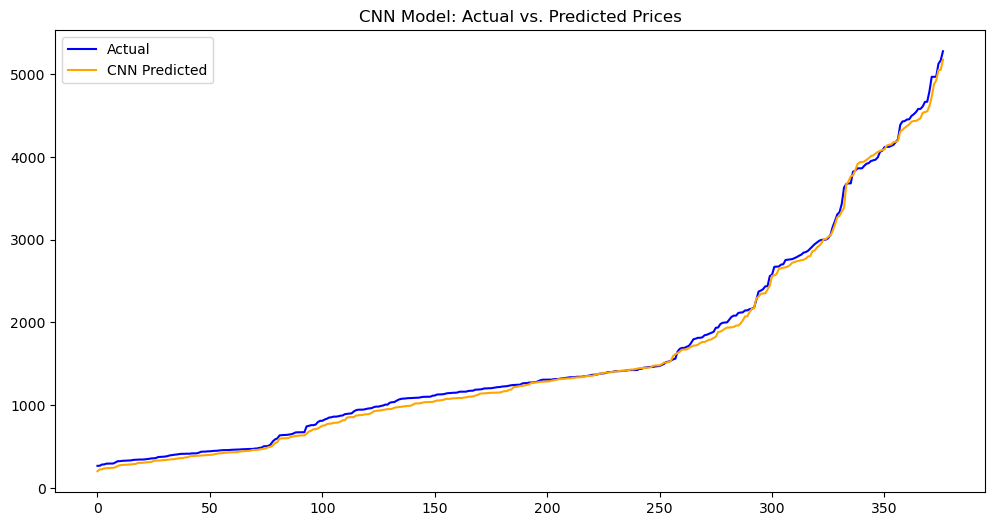

In [66]:
import matplotlib.pyplot as plt

# Plot actual vs. predicted values for FFNN
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test.values), label='Actual', color='blue')
plt.plot(sorted(ffnn_predictions.flatten()), label='FFNN Predicted', color='red')
plt.title('FFNN Model: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# Plot actual vs. predicted values for LSTM
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test_lstm_prepared), label='Actual', color='blue')
plt.plot(sorted(lstm_predictions.flatten()), label='LSTM Predicted', color='green')
plt.title('LSTM Model: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# Plot actual vs. predicted values for CNN
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test.values), label='Actual', color='blue')
plt.plot(sorted(cnn_predictions.flatten()), label='CNN Predicted', color='orange')
plt.title('CNN Model: Actual vs. Predicted Prices')
plt.legend()
plt.show()


# DAVE TILL HERE

# RAFAEL FROM HERE

### Step 3: Use Multiple Sets of Signals
We will evaluate the models using two sets of signals:

Set 1: Macroeconomic Signals:

GDP: Gross Domestic Product growth.
CPI: Inflation rate.
UN: Unemployment rate.
IR: Nominal interest rate.
Y10: 10Y treasury yield.
Economic Motivation: These indicators are fundamental to the overall economic environment and can significantly influence stock market movements. Changes in GDP, inflation, and interest rates are closely monitored by investors.

Set 2: Market and Technical Signals:

PE: Price/Earnings ratio.
DY: Dividend yield.
_MKT: Market returns.
_VA: Value index.
_GR: Growth index.
Economic Motivation: These indicators provide insight into market valuation and performance. They help understand the relative attractiveness of stocks and the broader market trends.

We will re-train and evaluate the models using these sets of signals.

## FFNN

Epoch 1/40


/Users/rafaeldubach/miniconda3/envs/DL/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3657926.2500 - val_loss: 3817676.0000
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - loss: 3641347.5000 - val_loss: 3745866.0000
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - loss: 3770165.7500 - val_loss: 3529211.7500
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 3245300.2500 - val_loss: 3112148.2500
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - loss: 2861782.2500 - val_loss: 2561796.0000
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 2438169.7500 - val_loss: 2067447.7500
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 1895966.0000 - val_loss: 1765645.3750
Epoch 8/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - loss: 1765700.6250 - val_loss: 1615076.3750
Epoch 9/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 1694974.5000 - val_loss: 1540794.1250
Epoch 10/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 1611907.3750 - val_loss: 1477105.2500
Epoch 11/40
66/66 ━━━━━━━━━━━━━━

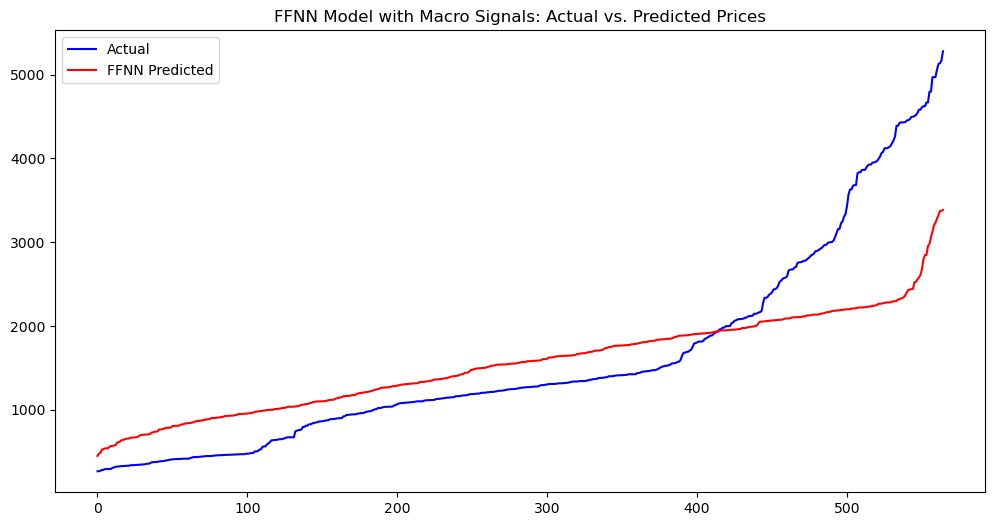

Epoch 1/40


/Users/rafaeldubach/miniconda3/envs/DL/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4031849.5000 - val_loss: 3812521.0000
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - loss: 3493615.2500 - val_loss: 3718485.2500
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 3676752.0000 - val_loss: 3449583.0000
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - loss: 3003187.0000 - val_loss: 2931815.5000
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 2614055.0000 - val_loss: 2209869.7500
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 1899355.2500 - val_loss: 1461483.2500
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 1234657.2500 - val_loss: 881196.3750
Epoch 8/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 817907.8125 - val_loss: 554718.0000
Epoch 9/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 575969.5625 - val_loss: 416335.1875
Epoch 10/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 428262.5000 - val_loss: 344971.8438
Epoch 11/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 

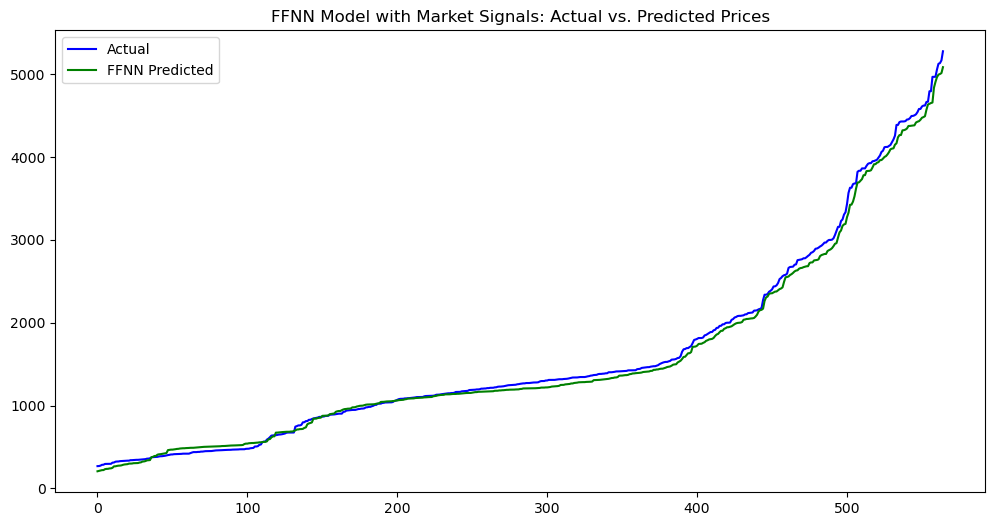

In [67]:
# ----------- Macroeconomic Signals Implementation -----------

# Define Macroeconomic Signals
macro_signals = ['gdp', 'cpi', 'un', 'ir', 'y10']

# Filter data for these signals
data_macro = data[macro_signals + ['snp']]
data_macro = data_macro.dropna()
features_macro = data_macro.drop(columns=['snp'])
target_macro = data_macro['snp']
features_macro_scaled = scaler.fit_transform(features_macro)

X_train_macro, X_test_macro, y_train_macro, y_test_macro = train_test_split(features_macro_scaled, target_macro, test_size=0.3, random_state=42)

ffnn_model_macro = create_ffnn_model(X_train_macro.shape[1])
ffnn_history_macro = ffnn_model_macro.fit(X_train_macro, y_train_macro, epochs=40, batch_size=16, validation_split=0.2, verbose=1)

ffnn_evaluation_macro = ffnn_model_macro.evaluate(X_test_macro, y_test_macro)
print(f"FFNN Model with Macro Signals Test Loss: {ffnn_evaluation_macro}")

ffnn_macro_predictions = ffnn_model_macro.predict(X_test_macro)
ffnn_macro_mse = mean_squared_error(sorted(y_test_macro), ffnn_macro_predictions)
ffnn_macro_r2 = r2_score(sorted(y_test_macro), ffnn_macro_predictions)
print(f"FFNN with Macro Signals MSE: {ffnn_macro_mse}")
print(f"FFNN with Macro Signals R-squared: {ffnn_macro_r2}")

plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test_macro.values), label='Actual', color='blue')
plt.plot(sorted(ffnn_macro_predictions.flatten()), label='FFNN Predicted', color='red')
plt.title('FFNN Model with Macro Signals: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# ----------- Market and Technical Signals Implementation -----------

# Define Market and Technical Signals
market_signals = ['pe', 'dy', '_mkt', '_va', '_gr']

# Filter data for these signals
data_market = data[market_signals + ['snp']]
data_market = data_market.dropna()
features_market = data_market.drop(columns=['snp'])
target_market = data_market['snp']
features_market_scaled = scaler.fit_transform(features_market)

X_train_market, X_test_market, y_train_market, y_test_market = train_test_split(features_market_scaled, target_market, test_size=0.3, random_state=42)

ffnn_model_market = create_ffnn_model(X_train_market.shape[1])
ffnn_history_market = ffnn_model_market.fit(X_train_market, y_train_market, epochs=40, batch_size=16, validation_split=0.2, verbose=1)

ffnn_evaluation_market = ffnn_model_market.evaluate(X_test_market, y_test_market)
print(f"FFNN Model with Market Signals Test Loss: {ffnn_evaluation_market}")

ffnn_market_predictions = ffnn_model_market.predict(X_test_market)
ffnn_market_mse = mean_squared_error(sorted(y_test_market), ffnn_market_predictions)
ffnn_market_r2 = r2_score(sorted(y_test_market), ffnn_market_predictions)
print(f"FFNN with Market Signals MSE: {ffnn_market_mse}")
print(f"FFNN with Market Signals R-squared: {ffnn_market_r2}")

plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test_market.values), label='Actual', color='blue')
plt.plot(sorted(ffnn_market_predictions.flatten()), label='FFNN Predicted', color='green')
plt.title('FFNN Model with Market Signals: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# LSTM

Epoch 1/100


/Users/rafaeldubach/miniconda3/envs/DL/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1345601.0000 - val_loss: 12303297.0000
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1415582.1250 - val_loss: 12299757.0000
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1380061.8750 - val_loss: 12292899.0000
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1396639.7500 - val_loss: 12280519.0000
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1373713.8750 - val_loss: 12258299.0000
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1295191.3750 - val_loss: 12220351.0000
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1373210.6250 - val_loss: 12158217.0000
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1270420.0000 - val_loss: 12063501.0000
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1308931.0000 - val_loss: 11936174.0000
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1183642.6250 - val_loss: 11775321.0000
Epoch 11/100
38/38 ━━━━━━━━━━━━

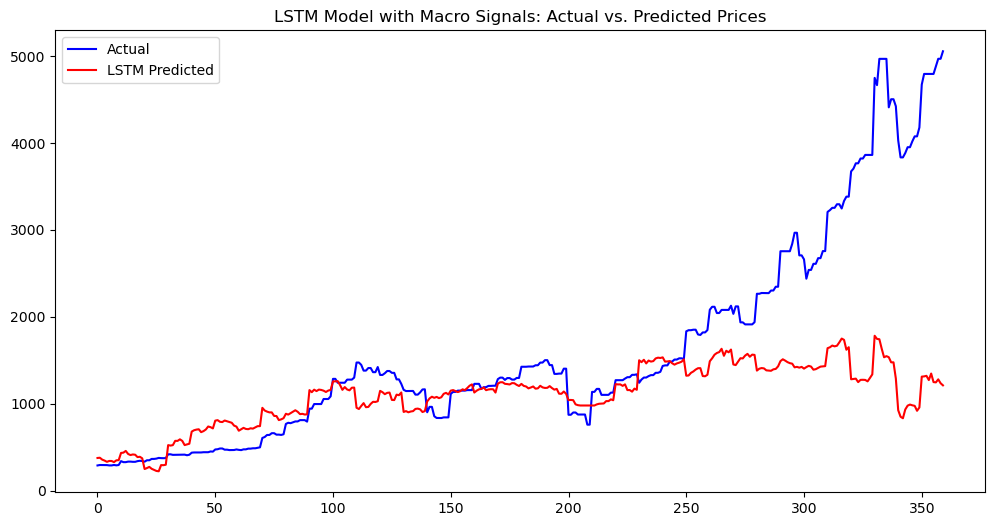

Epoch 1/100


/Users/rafaeldubach/miniconda3/envs/DL/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1378901.1250 - val_loss: 12302880.0000
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1410277.7500 - val_loss: 12298487.0000
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1392793.1250 - val_loss: 12289386.0000
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1383641.8750 - val_loss: 12270856.0000
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1419344.3750 - val_loss: 12234897.0000
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1365199.0000 - val_loss: 12163140.0000
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1372697.8750 - val_loss: 12038141.0000
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1288061.1250 - val_loss: 11828627.0000
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1280765.8750 - val_loss: 11482774.0000
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1174781.1250 - val_loss: 10990769.0000
Epoch 11/100
38/38 ━━━━━━━━━━━━

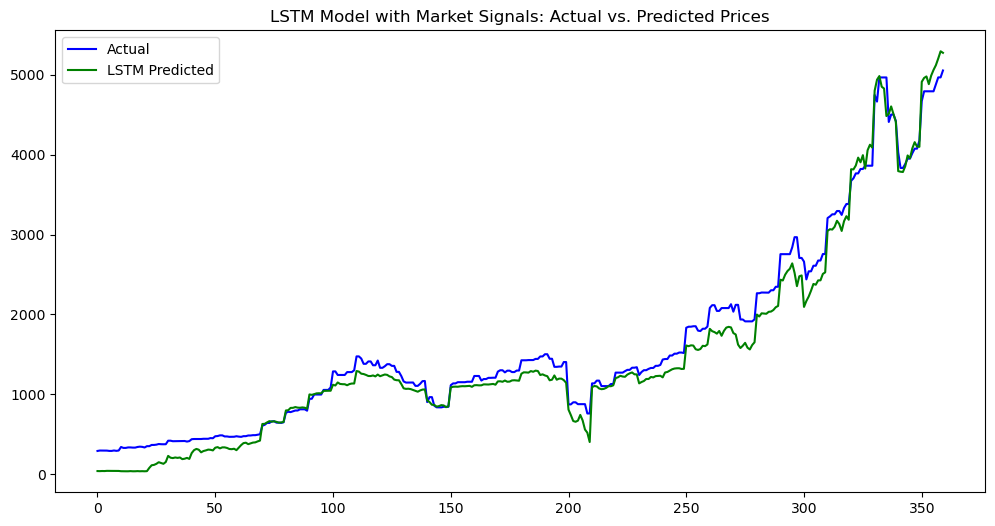

In [68]:
# ----------- Macroeconomic Signals Implementation -----------

# Define Macroeconomic Signals
macro_signals = ['gdp', 'cpi', 'un', 'ir', 'y10']

# Filter and reshape data for these signals
data_macro = data[macro_signals + ['snp']]
data_macro = data_macro.dropna()
features_macro = data_macro.drop(columns=['snp'])
target_macro = data_macro['snp']
features_macro_scaled = scaler.fit_transform(features_macro)

# Split the data using the custom function
X_train_macro_prepared, y_train_macro_prepared, X_test_macro_prepared, y_test_macro_prepared = custom_train_test_split(features_macro_scaled, target_macro)

# Reshape data for LSTM (needs 3D input)
X_train_macro_lstm = X_train_macro_prepared.reshape((X_train_macro_prepared.shape[0], 1, X_train_macro_prepared.shape[1]))
X_test_macro_lstm = X_test_macro_prepared.reshape((X_test_macro_prepared.shape[0], 1, X_test_macro_prepared.shape[1]))

lstm_model_macro = create_lstm_model((X_train_macro_lstm.shape[1], X_train_macro_lstm.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Increased patience
lstm_history_macro = lstm_model_macro.fit(X_train_macro_lstm, y_train_macro_prepared, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stop])  # Increased epochs

lstm_evaluation_macro = lstm_model_macro.evaluate(X_test_macro_lstm, y_test_macro_prepared)
print(f"LSTM Model with Macro Signals Test Loss: {lstm_evaluation_macro}")

lstm_macro_predictions = lstm_model_macro.predict(X_test_macro_lstm)
lstm_macro_mse = mean_squared_error(y_test_macro_prepared, lstm_macro_predictions)
lstm_macro_r2 = r2_score(y_test_macro_prepared, lstm_macro_predictions)
print(f"LSTM with Macro Signals MSE: {lstm_macro_mse}")
print(f"LSTM with Macro Signals R-squared: {lstm_macro_r2}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_macro_prepared, label='Actual', color='blue')
plt.plot(lstm_macro_predictions.flatten(), label='LSTM Predicted', color='red')
plt.title('LSTM Model with Macro Signals: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# ----------- Market and Technical Signals Implementation -----------

# Define Market and Technical Signals
market_signals = ['pe', 'dy', '_mkt', '_va', '_gr']

# Filter and reshape data for these signals
data_market = data[market_signals + ['snp']]
data_market = data_market.dropna()
features_market = data_market.drop(columns=['snp'])
target_market = data_market['snp']
features_market_scaled = scaler.fit_transform(features_market)

# Split the data using the custom function
X_train_market_prepared, y_train_market_prepared, X_test_market_prepared, y_test_market_prepared = custom_train_test_split(features_market_scaled, target_market)

# Reshape data for LSTM (needs 3D input)
X_train_market_lstm = X_train_market_prepared.reshape((X_train_market_prepared.shape[0], 1, X_train_market_prepared.shape[1]))
X_test_market_lstm = X_test_market_prepared.reshape((X_test_market_prepared.shape[0], 1, X_test_market_prepared.shape[1]))

lstm_model_market = create_lstm_model((X_train_market_lstm.shape[1], X_train_market_lstm.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Increased patience
lstm_history_market = lstm_model_market.fit(X_train_market_lstm, y_train_market_prepared, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stop])  # Increased epochs

lstm_evaluation_market = lstm_model_market.evaluate(X_test_market_lstm, y_test_market_prepared)
print(f"LSTM Model with Market Signals Test Loss: {lstm_evaluation_market}")

lstm_market_predictions = lstm_model_market.predict(X_test_market_lstm)
lstm_market_mse = mean_squared_error(y_test_market_prepared, lstm_market_predictions)
lstm_market_r2 = r2_score(y_test_market_prepared, lstm_market_predictions)
print(f"LSTM with Market Signals MSE: {lstm_market_mse}")
print(f"LSTM with Market Signals R-squared: {lstm_market_r2}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_market_prepared, label='Actual', color='blue')
plt.plot(lstm_market_predictions.flatten(), label='LSTM Predicted', color='green')
plt.title('LSTM Model with Market Signals: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# CNN

Epoch 1/40


/Users/rafaeldubach/miniconda3/envs/DL/lib/python3.9/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3911002.0000 - val_loss: 3432082.0000
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2917664.5000 - val_loss: 1416815.5000
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1429146.3750 - val_loss: 1332800.0000
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1364519.8750 - val_loss: 1291389.3750
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1274304.0000 - val_loss: 1245956.2500
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1370565.6250 - val_loss: 1216938.6250
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1386165.6250 - val_loss: 1214978.0000
Epoch 8/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1286083.5000 - val_loss: 1167198.2500
Epoch 9/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1265730.1250 - val_loss: 1132909.5000
Epoch 10/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1204392.2500 - val_loss: 1100685.8750
Epoch 11/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

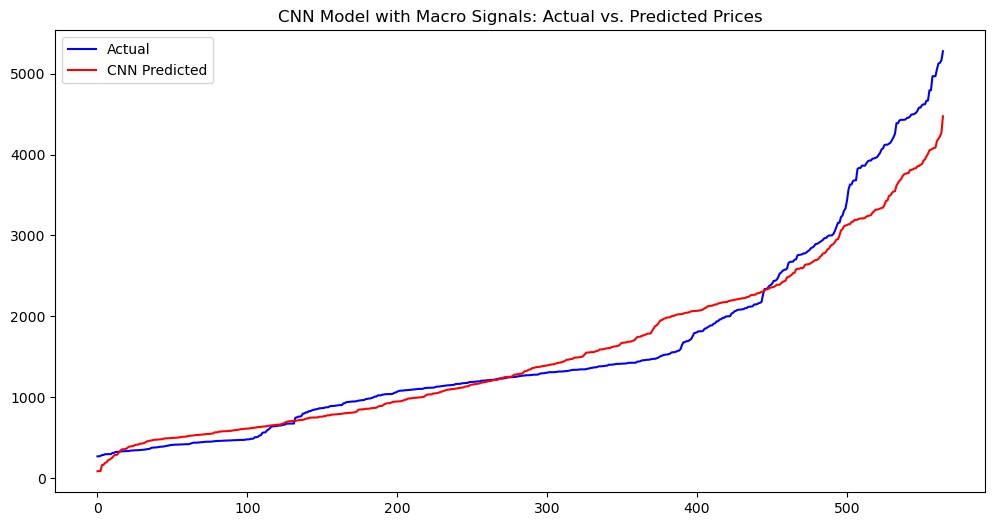

Epoch 1/40


/Users/rafaeldubach/miniconda3/envs/DL/lib/python3.9/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4020781.7500 - val_loss: 3488836.0000
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2493726.2500 - val_loss: 642709.0000
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 778403.1250 - val_loss: 477977.4375
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 539970.5000 - val_loss: 298656.8750
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 315997.9062 - val_loss: 143796.7031
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 133536.3125 - val_loss: 52212.9336
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 53265.2695 - val_loss: 26162.9980
Epoch 8/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30998.1602 - val_loss: 21662.4102
Epoch 9/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27332.7148 - val_loss: 18746.3105
Epoch 10/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24307.1699 - val_loss: 16064.7334
Epoch 11/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21739.9824 - val_

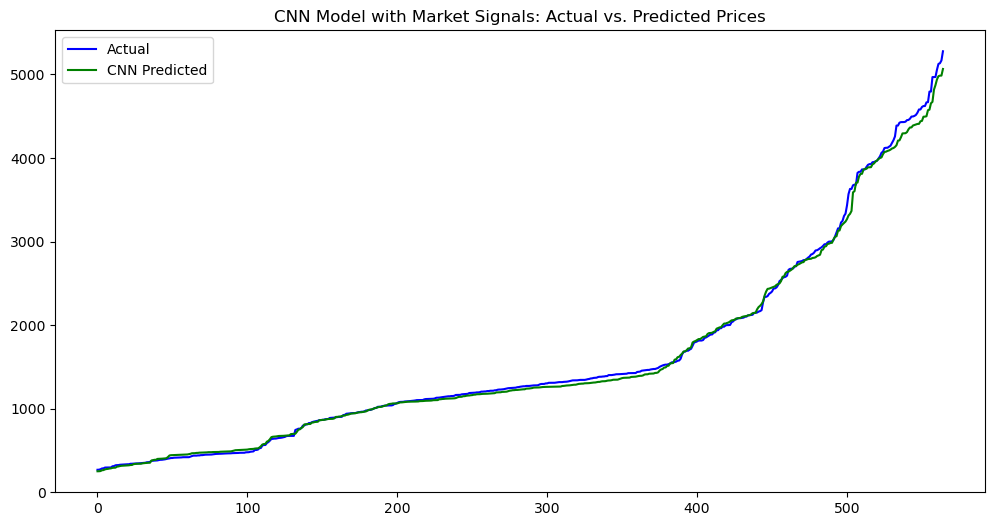

In [69]:
# ----------- Macroeconomic Signals Implementation -----------

# Define Macroeconomic Signals
macro_signals = ['gdp', 'cpi', 'un', 'ir', 'y10']

# Filter data for these signals
data_macro = data[macro_signals + ['snp']]
data_macro = data_macro.dropna()
features_macro = data_macro.drop(columns=['snp'])
target_macro = data_macro['snp']
features_macro_scaled = scaler.fit_transform(features_macro)

X_train_macro, X_test_macro, y_train_macro, y_test_macro = train_test_split(features_macro_scaled, target_macro, test_size=0.3, random_state=42)

cnn_model_macro = create_cnn_model(X_train_macro.shape[1])
cnn_history_macro = cnn_model_macro.fit(X_train_macro, y_train_macro, epochs=40, batch_size=16, validation_split=0.2, verbose=1)

cnn_evaluation_macro = cnn_model_macro.evaluate(X_test_macro, y_test_macro)
print(f"CNN Model with Macro Signals Test Loss: {cnn_evaluation_macro}")

cnn_macro_predictions = cnn_model_macro.predict(X_test_macro)
cnn_macro_mse = mean_squared_error(sorted(y_test_macro), cnn_macro_predictions)
cnn_macro_r2 = r2_score(sorted(y_test_macro), cnn_macro_predictions)
print(f"CNN with Macro Signals MSE: {cnn_macro_mse}")
print(f"CNN with Macro Signals R-squared: {cnn_macro_r2}")

plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test_macro.values), label='Actual', color='blue')
plt.plot(sorted(cnn_macro_predictions.flatten()), label='CNN Predicted', color='red')
plt.title('CNN Model with Macro Signals: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# ----------- Market and Technical Signals Implementation -----------

# Define Market and Technical Signals
market_signals = ['pe', 'dy', '_mkt', '_va', '_gr']

# Filter data for these signals
data_market = data[market_signals + ['snp']]
data_market = data_market.dropna()
features_market = data_market.drop(columns=['snp'])
target_market = data_market['snp']
features_market_scaled = scaler.fit_transform(features_market)

X_train_market, X_test_market, y_train_market, y_test_market = train_test_split(features_market_scaled, target_market, test_size=0.3, random_state=42)

cnn_model_market = create_cnn_model(X_train_market.shape[1])
cnn_history_market = cnn_model_market.fit(X_train_market, y_train_market, epochs=40, batch_size=16, validation_split=0.2, verbose=1)

cnn_evaluation_market = cnn_model_market.evaluate(X_test_market, y_test_market)
print(f"CNN Model with Market Signals Test Loss: {cnn_evaluation_market}")

cnn_market_predictions = cnn_model_market.predict(X_test_market)
cnn_market_mse = mean_squared_error(sorted(y_test_market), cnn_market_predictions)
cnn_market_r2 = r2_score(sorted(y_test_market), cnn_market_predictions)
print(f"CNN with Market Signals MSE: {cnn_market_mse}")
print(f"CNN with Market Signals R-squared: {cnn_market_r2}")

plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test_market.values), label='Actual', color='blue')
plt.plot(sorted(cnn_market_predictions.flatten()), label='CNN Predicted', color='green')
plt.title('CNN Model with Market Signals: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# DAVE AB HIER WIEDER

### Step 4: In-sample and Out-of-sample Performance
In-sample Predictions and Plotting:

Evaluate the in-sample performance using training data.
Compare the in-sample predictions to the actual values.
Plot the actual vs. predicted values for in-sample data.

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
FFNN In-sample MSE: 4817.549425768297
FFNN In-sample R-squared: 0.996291645788905


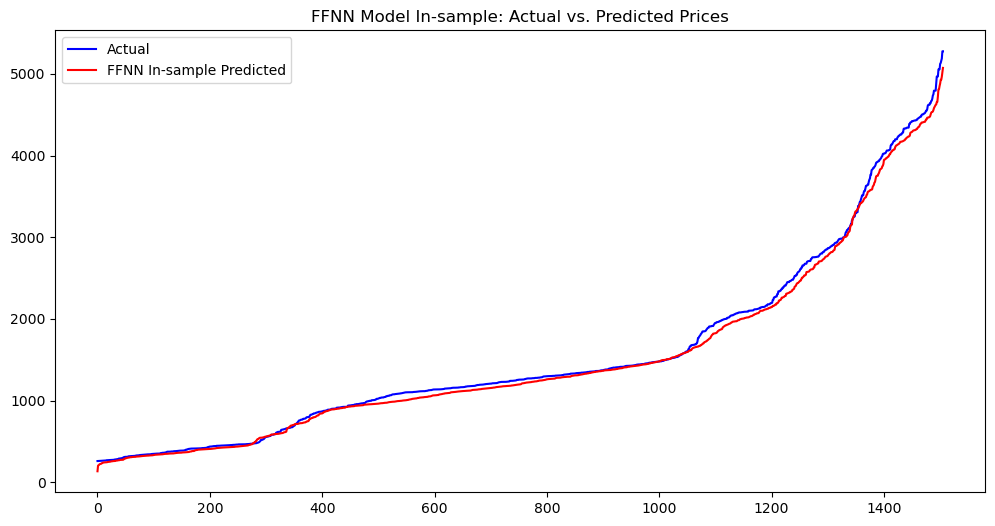

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step
LSTM In-sample MSE: 160279.10177552392
LSTM In-sample R-squared: 0.8693419211019635


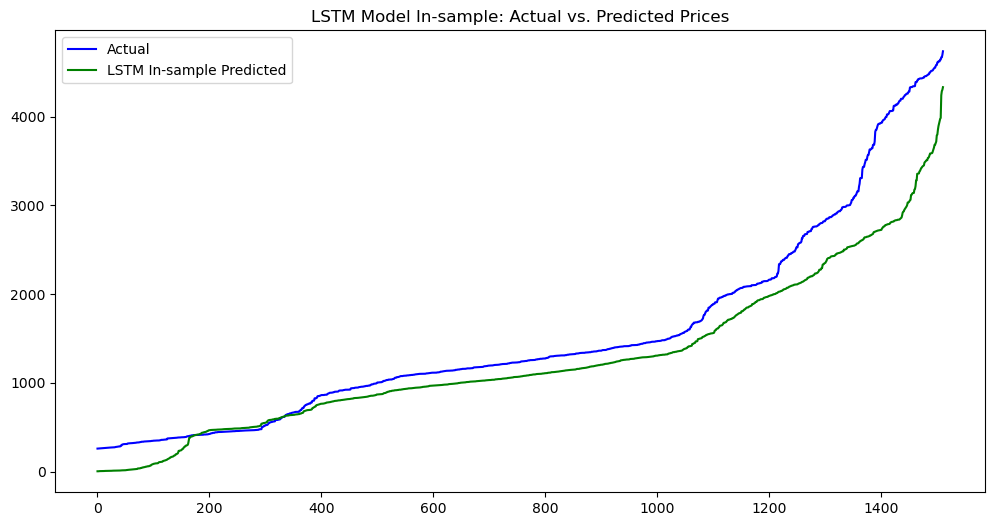

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
CNN In-sample MSE: 6002571.569037586
CNN In-sample R-squared: -3.6205362079684464


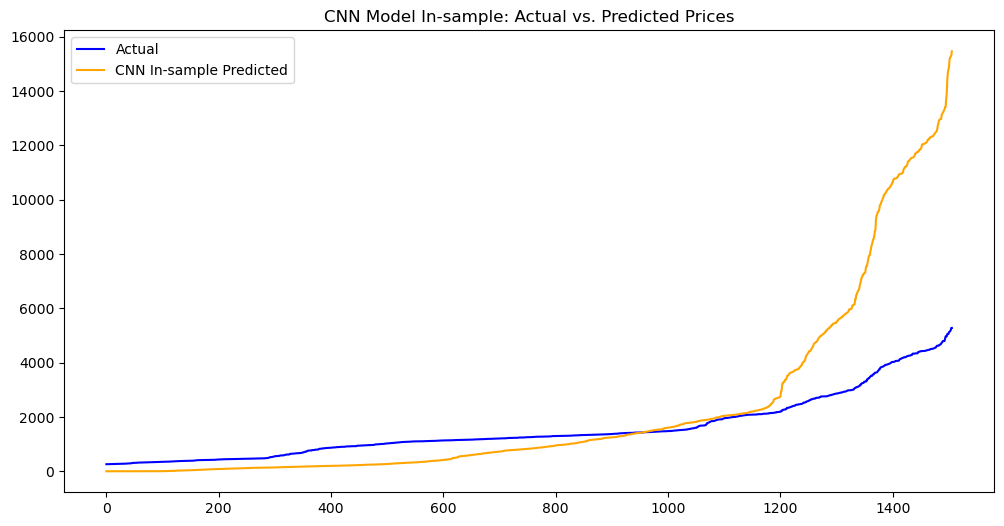

In [70]:
# In-sample predictions for FFNN
ffnn_in_sample_predictions = ffnn_model.predict(X_train)
ffnn_in_sample_mse = mean_squared_error(sorted(y_train), sorted(ffnn_in_sample_predictions))
ffnn_in_sample_r2 = r2_score(sorted(y_train), sorted(ffnn_in_sample_predictions))
print(f"FFNN In-sample MSE: {ffnn_in_sample_mse}")
print(f"FFNN In-sample R-squared: {ffnn_in_sample_r2}")

# Plot actual vs. predicted values for in-sample data (FFNN)
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_train.values), label='Actual', color='blue')
plt.plot(sorted(ffnn_in_sample_predictions.flatten()), label='FFNN In-sample Predicted', color='red')
plt.title('FFNN Model In-sample: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# In-sample predictions for LSTM
lstm_in_sample_predictions = lstm_model.predict(X_train_lstm)
lstm_in_sample_mse = mean_squared_error(sorted(y_train_lstm_prepared), sorted(lstm_in_sample_predictions))
lstm_in_sample_r2 = r2_score(sorted(y_train_lstm_prepared), sorted(lstm_in_sample_predictions))
print(f"LSTM In-sample MSE: {lstm_in_sample_mse}")
print(f"LSTM In-sample R-squared: {lstm_in_sample_r2}")

# Plot actual vs. predicted values for in-sample data (LSTM)
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_train_lstm_prepared), label='Actual', color='blue')
plt.plot(sorted(lstm_in_sample_predictions.flatten()), label='LSTM In-sample Predicted', color='green')
plt.title('LSTM Model In-sample: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# In-sample predictions for CNN
cnn_in_sample_predictions = cnn_model.predict(X_train)
cnn_in_sample_mse = mean_squared_error(sorted(y_train), sorted(cnn_in_sample_predictions))
cnn_in_sample_r2 = r2_score(sorted(y_train), sorted(cnn_in_sample_predictions))
print(f"CNN In-sample MSE: {cnn_in_sample_mse}")
print(f"CNN In-sample R-squared: {cnn_in_sample_r2}")

# Plot actual vs. predicted values for in-sample data (CNN)
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_train.values), label='Actual', color='blue')
plt.plot(sorted(cnn_in_sample_predictions.flatten()), label='CNN In-sample Predicted', color='orange')
plt.title('CNN Model In-sample: Actual vs. Predicted Prices')
plt.legend()
plt.show()


Out-of-sample Predictions and Plotting:

Evaluate the out-of-sample performance using testing data (already calculated).
Compare the out-of-sample predictions to the actual values.
Plot the actual vs. predicted values for out-of-sample data.

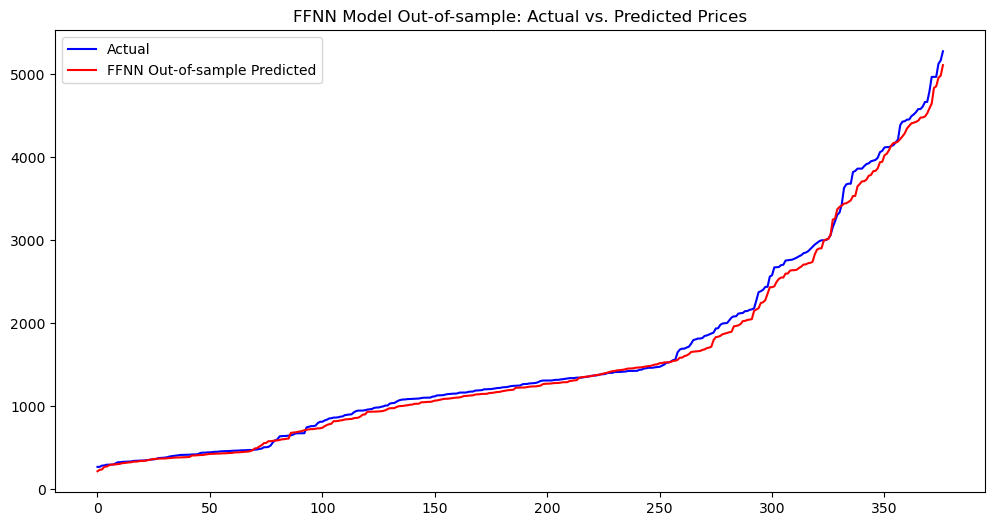

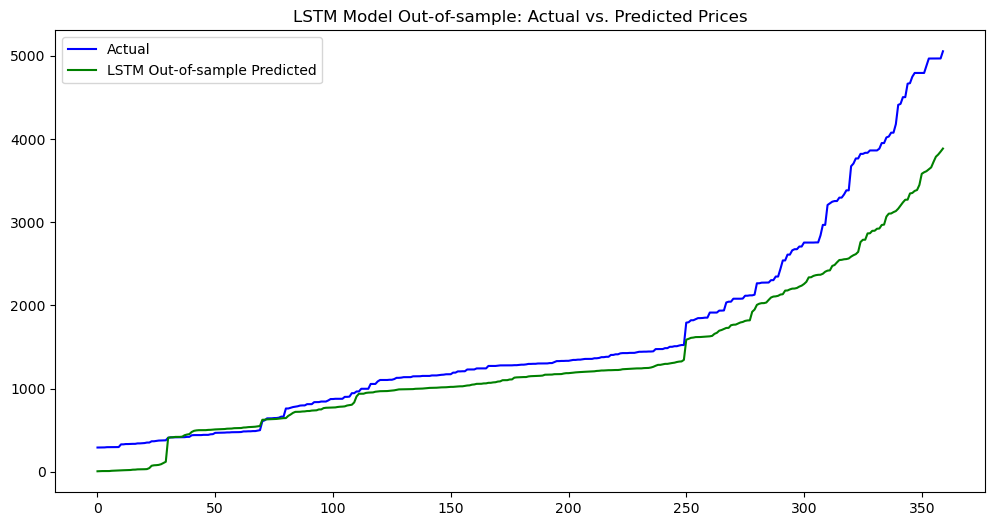

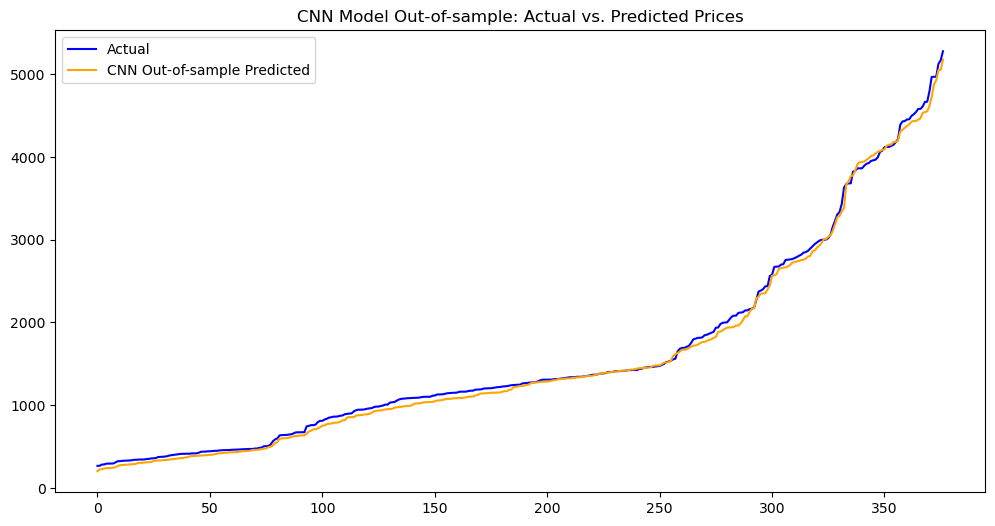

In [71]:
# Out-of-sample predictions for FFNN
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test.values), label='Actual', color='blue')
plt.plot(sorted(ffnn_predictions.flatten()), label='FFNN Out-of-sample Predicted', color='red')
plt.title('FFNN Model Out-of-sample: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# Out-of-sample predictions for LSTM
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test_lstm_prepared), label='Actual', color='blue')
plt.plot(sorted(lstm_predictions.flatten()), label='LSTM Out-of-sample Predicted', color='green')
plt.title('LSTM Model Out-of-sample: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# Out-of-sample predictions for CNN
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test.values), label='Actual', color='blue')
plt.plot(sorted(cnn_predictions.flatten()), label='CNN Out-of-sample Predicted', color='orange')
plt.title('CNN Model Out-of-sample: Actual vs. Predicted Prices')
plt.legend()
plt.show()

### Step 5: Analyze Hypotheses and Results
We will form hypotheses based on our two sets of signals and compare the results to these expectations.

Hypotheses:

Macroeconomic Signals:

Hypothesis: Macroeconomic indicators such as GDP, CPI, and interest rates significantly influence the S&P 500 movements, and models using these signals will have strong predictive power.
Expected Results: Higher R-squared values and lower MSE for models trained with macroeconomic signals compared to other signals.
Market and Technical Signals:

Hypothesis: Market and technical indicators, such as P/E ratio, dividend yield, and market returns, provide a closer insight into stock market valuation and performance. These signals should lead to better short-term predictive performance.
Expected Results: More accurate short-term predictions reflected in tighter alignment of actual vs. predicted values.
Evaluate and Discuss Results:

Compare the in-sample and out-of-sample performance of models using different sets of signals.
Discuss whether the results support the initial hypotheses.

In [72]:
# Evaluate FFNN with macro signals
ffnn_macro_predictions = ffnn_model_macro.predict(X_test_macro)
ffnn_macro_mse = mean_squared_error(y_test_macro, ffnn_macro_predictions)
ffnn_macro_r2 = r2_score(y_test_macro, ffnn_macro_predictions)
print(f"FFNN with Macro Signals MSE: {ffnn_macro_mse}")
print(f"FFNN with Macro Signals R-squared: {ffnn_macro_r2}")

# Evaluate FFNN with market signals
ffnn_market_predictions = ffnn_model_market.predict(X_test_market)
ffnn_market_mse = mean_squared_error(y_test_market, ffnn_market_predictions)
ffnn_market_r2 = r2_score(y_test_market, ffnn_market_predictions)
print(f"FFNN with Market Signals MSE: {ffnn_market_mse}")
print(f"FFNN with Market Signals R-squared: {ffnn_market_r2}")

# Compare in-sample and out-of-sample performance
print(f"In-sample R-squared: {ffnn_in_sample_r2}")
print(f"Out-of-sample R-squared: {ffnn_r2}")

# Discuss whether the results support the initial hypotheses
if ffnn_macro_r2 > ffnn_market_r2:
    print("Macroeconomic signals provided better predictive power.")
else:
    print("Market and technical signals provided better predictive power.")


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
FFNN with Macro Signals MSE: 786093.3612177956
FFNN with Macro Signals R-squared: 0.4470889417439373
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
FFNN with Market Signals MSE: 13342.122309646473
FFNN with Market Signals R-squared: 0.9906156096342295
In-sample R-squared: 0.996291645788905
Out-of-sample R-squared: 0.987987247744591
Market and technical signals provided better predictive power.


### Summary
Calculated Model Accuracy: We used MSE and R-squared to evaluate model performance.
Visualized Results: Plotted actual vs. predicted values for both in-sample and out-of-sample data.
Used Multiple Signal Sets: Evaluated models with macroeconomic and market/technical signals, providing economic motivation.
Analyzed Hypotheses: Formulated and tested hypotheses based on signal sets and discussed the results.
This comprehensive approach ensures we have a detailed analysis and understanding of the performance of our trading algorithm. If you need any further details or additional steps, please let me know!